In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("drive/My Drive/Colab Notebooks/IFT2015/")
#check if you are in the right directory
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
 example.bed
 GCF_000002985.6_WBcel235_rna.fna.gz
 graph_yq.ipynb
 graph_yq.py
 ift2015-travail-pratique-2.pdf
'Introduction aux formats de fichiers et algorithmes utilisés dans le TP2_copy.ipynb'
 main_yq_bak.ipynb
 main_yq.ipynb
 Note_BinarySearchTree.ipynb
 __pycache__
 reads.fastq.gz
 TP2_JX_colab.ipynb


## Question 2

### a) Encoder tous les k-mers des fragments fournis dans le fichier FASTQ dans une instance du graphe De Brujin. Chaque fragment possède l − k + 1 k-mers.

### Answer a)
**Step1**: Import `DeBrujinGraph` implemented in question1 and other necessary modules

In [26]:
import gzip
from itertools import islice
from graph_yq import DeBrujinGraph
import time

**Step2**: Use the method `read_fastq` provided to load sequences from file: 'reads.fastq.gz' and generate possible k-mers with k = 21.

In [0]:
def read_fastq(path):
    with gzip.open(path, 'rt') as f:
        for line in f:
            seqid, description = line[1:].rstrip().split(maxsplit = 1)
            sequence = f.readline().rstrip()
            _ = f.readline()
            quality = f.readline().rstrip()
            yield seqid, description, sequence, quality

In [0]:
k = 21
kmers = []

In [6]:
%%time
for _, _, seq, _ in read_fastq('reads.fastq.gz'):
    kmers.extend([seq[i:i+k] for i in range(len(seq) - k + 1)])

CPU times: user 2.54 s, sys: 725 ms, total: 3.26 s
Wall time: 3.83 s


**Step3**: Build an instance of `DeBrujinGraph` based on all k-mers.

In [7]:
%%time
length = len(kmers) # min(20000, len(kmers))
print(length)
graph = DeBrujinGraph(nodes = kmers[:length], k = 21)

1545426787.6845381
8627600
building nodes...
building edges...
CPU times: user 30min 52s, sys: 9.26 s, total: 31min 1s
Wall time: 31min 1s


**Step4**: View the node and edge counts of the graph generated.

In [8]:
print("node counts:", graph.node_count())
print("edge counts:", graph.edge_count())

node counts: 5126513
edge counts: 5091467


### b) Bonus: Implanter une table de hachage plus rapide que celle de CPython (i.e. celle utilisée par set et dict) pour stocker des k-mers pour les opérations effectuées en 2a.

### Answer b)



<hr>

## Question 3 

### a)  Parcourir le graphe pour obtenir des segments contigüs que vous devrez stocker dans un fichier FASTA nommé contigs.fa avec un identifiant unique pour chacun. 
Commencer par identifier les noeuds qui n’ont pas de prédécesseurs pour débuter l’exploration.

Alternativement, vous pouvez explorer le graphe dans les deux directions en partant d’un point aléatoire sur chaque composante connexe.

### Answer a)

**Step1**: Implement deep first search and breadth first search methods `DFS`, `DFS_complete`, `BFS`; these methods will be used to explore the connected components of the graph.

In [0]:
def DFS(g, u, discovered, dest_nodes):
    """deep first search of a graph.
    params
        g: a graph
        u: a node of graph g
        discovered: a dictionary marking where a edge is visited
    return
        None, discovered dict will be modified
    """
    for v in g.successors( u ):
        if v not in discovered:
            discovered[v] = u # u represents parent node of v
                              # v carries the edge information v[-1]
            dest_nodes.add(v)
            dest_nodes.discard(u)
            DFS( g, v, discovered, dest_nodes )
            
            
def BFS(g, s, discovered, dest_nodes):
    level = [s]
    while len(level) > 0:
        next_level = []
        for u in level:
            for v in g.successors(u):
                if v not in discovered:
                    discovered[v] = u
                    dest_nodes.add(v)
                    dest_nodes.discard(u)
                    next_level.append(v)
        level = next_level
        
            
def DFS_complete(g):
    """use DFS to return a forest with connected components
    params
        g: graph
    returns
        forest: dict, if value of a key is None, this key has no
    predecessors, therefore it is a root of a tree in the forest
    """
    forest = {}
    dest_nodes = set()
    for u in g:
        if u not in forest:
            forest[u] = None
            DFS(g, u, forest, dest_nodes)
    return forest, dest_nodes

            
def build_segments(g, u, discovered, segments):
    """build segments
    """
    for v in g.successors(u):
        if v not in discovered:
            discoverd[v] = v[-1]
            segments[-1] += v[-1]
            DFS(g, v, discovered, segments)
        else:
            
            

**Step2**: Implement method `find_nodes` for finding nodes without predecessors or without successors.

In [0]:
# find the nodes who have no predecessors
def find_end_nodes(g, is_origin = True):
    """find all nodes without predecessors or without successors controled by
    a bool parameter
    params
        g: graph
        has_no_predecessors: bool, if True, find all nodes without predecessors,
            If False, find all nodes without successors
    returns
        results, list of nodes
    """
    results = []
    func = g.predecessors
    if is_origin == False:
        func = g.successors
    for node in g.nodes():
        if len(func(node)) == 0: # no predecessors
            results.append(node)
    return results           

**Step3**: There might be cycles in a DeBrujin graph, which may lead to a phenomenon that all nodes have predecessors or successors. Here are the three possible cases for a DeBrujin graph:

1. One or more nodes have no predecessors, one or more nodes have successors
2. No node has no predecessors, one or more nodes have successors
3. No node has no predecessors; no node has no successors

First, let's consider case1. We can find all possible paths by starting from a node without predecessors and ended to its accessible node who has no successors. Based on the paths found, a continuous sequence will be assembled.

In [0]:
def build_segment( g, u, v, discovered ):
    """build a fragment from node u to v based on the discovered paths in graph
    params
        g: graph
        u: start node of a fragment, str
        v: end node of a fragment, str
        discovered: dictionary from a deep first search of a graph g
    returns
        segment: str
    """
    visited = set()
    if u is None: # there is no start nodes
        pass
    
    segment = []
    if v in discovered:
        walk = v
        while walk is not u:
            parent = discovered[walk]
            segment.append(walk[-1])
            walk = parent
        # walk is now u
        
    segment.reverse()
    segment = u + "".join(segment)
    return segment

In [0]:
def generate_segments(g, origin_nodes):
    segments = []
    for origin_node in origin_nodes:
        discovered = {origin_node: '-'}
        dest_nodes = set(origin_node)
        DFS(graph, origin_node, discovered, dest_nodes)
        #BFS(graph, origin_node, discovered, dest_nodes)
        for dest_node in dest_nodes:
            segment = build_segment(graph, origin_node, dest_node, discovered)
            segments.append(segment)
    
    return segments

use small graph to experiment

In [27]:
import random
def random_kmer(k):
    return ''.join(random.choices("ATCG", k = k))

k = 5
k_mers = [random_kmer(k) for i in range(200)]
graph2 = DeBrujinGraph(nodes = k_mers, k = k)

building nodes...
building edges...


In [56]:
print(graph2.edge_count())

138


In [37]:
%%time
origin_nodes = find_end_nodes(graph, is_origin = True)

CPU times: user 4min 50s, sys: 32 ms, total: 4min 50s
Wall time: 4min 50s


In [0]:
import sys
sys.getrecursionlimit()
sys.setrecursionlimit(10000)

In [46]:
%%time
segments = generate_segments(graph, origin_nodes)
print(len(segments))

199640
CPU times: user 5min 37s, sys: 97 ms, total: 5min 37s
Wall time: 5min 37s


In [28]:
for segment in segments[:200]:
    print(len(segment), segment)

21 AACGAAGATCGGATACACGTA
21 AACGAAGATCGGATACACGTA
21 AACGAAGATCGGATACACGTA
21 AACGAAGATCGGATACACGTA
100 AACGAAGATCGGATACACGTACACCGACTCGAGTGCGCGTCTGATGGTGGAATTCTCGATATGGATGATGTTTTAGAAGAAGTTTTTGATTTGAATTATG
21 AAACAAATCATTGGCTAGCAG
21 AAACAAATCATTGGCTAGCAG
21 AAACAAATCATTGGCTAGCAG
147 AAACAAATCATTGGCTAGCAGCCGGTCGTCAACCATATTTGGACCATTATTCGCCGGAAACACTCCGGACACAATGGGCGGCACTTTGTGACGTCGTAGATCAAGTTCACTCGTTCTGCGGTGGCCGTTTCCCGTGTGACCTGGTAC
21 AAACAAATCATTGGCTAGCAG
21 ACAGCAACGTCAAGCGGGTTC
100 ACAGCAACGTCAAGCGGGTTCTTCATCGCGAGCAGTTCCACCTGCATCTGCATCCACGTCAGCAGCTTCTGGAATCACGGATTTGAGTATGGCAGATAAG
21 ACAGCAACGTCAAGCGGGTTC
21 ACAGCAACGTCAAGCGGGTTC
21 ACAGCAACGTCAAGCGGGTTC
21 TCAAGCAGAAGAGACTTTGAA
100 TCAAGCAGAAGAGACTTTGAAGAAAAATCAAATCGGAAAAATTTGCACTACTTTCAAATATTCAGAGCTCGGAAAGTCTGTGTTCAAAGAGTCTAGTGGT
21 TCAAGCAGAAGAGACTTTGAA
21 TCAAGCAGAAGAGACTTTGAA
21 TCAAGCAGAAGAGACTTTGAA
154 CACCTCTGAATACTGTAGAAAGGTATGATCCTCGAGTTGGAAAGTGGGAAGAAGTTCGACCGATGCTAACCAAACGAAAGCATCTTGGAACAGCGGTTTATGATGGATACATTTATGCGGTTGGTGGAA

21 5862


(array([1.94241e+05, 4.24700e+03, 9.85000e+02, 1.41000e+02, 1.70000e+01,
        7.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  21. ,  605.1, 1189.2, 1773.3, 2357.4, 2941.5, 3525.6, 4109.7,
        4693.8, 5277.9, 5862. ]),
 <a list of 10 Patch objects>)

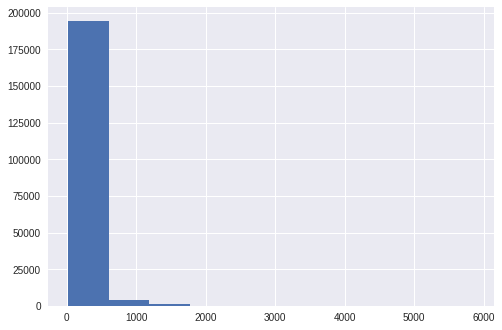

In [48]:
import matplotlib.pyplot as plt

lens = [len(i) for i in segments]
print(min(lens), max(lens))


(array([     0.,      0., 149052.,  48588.,   2000.]),
 array([    0,     1,    10,   100,  1000, 10000]),
 <a list of 5 Patch objects>)

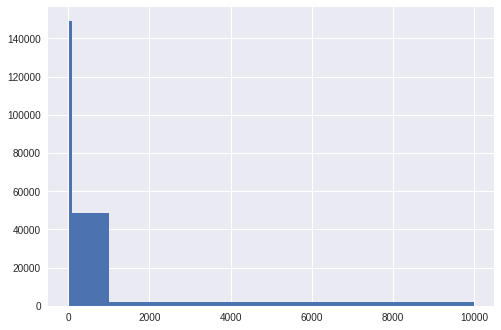

In [51]:
plt.hist(lens, [0, 1, 10, 100, 1000, 10000])

In [0]:
def exist_same_segment(segments):
    """check if there exists two identical segments
    """
    for i in range(len(segments)):
        for j in range(i+1, len(segments)):
            if segments[i] == segments[j]:
                return True, i, j
    return False

In [0]:
exist_same_segment(segments)

In [0]:
def read_fasta(path):
    with gzip.open(path, 'rt') as f:
        accession, description, seq = None, None, None
        for line in f:
            if line[0] == '>':
                # yield current record
                if accession is not None:
                    yield accession, description, seq
                    
                # start a new record
                accession, description = line[1:].rstrip().split(maxsplit=1)
                seq = ''
            else:
                seq += line.rstrip()

In [0]:
# test graph with small k and seq 

seq = "ATGTGATGAATGTGATCGGCGAGGCAAAACAAC"
k = 9
kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
graph2 = DeBrujinGraph(kmers, k = k)

start_nodes = find_nodes(graph2)
end_nodes = find_nodes(graph2, False)
print(start_nodes)
print(end_nodes)

import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

def edges(kmers_graph):
    for k in kmers_graph:
        for s in 'ATCG':
            successor = k[1:] + s
            if successor in kmers_graph:
                yield k, successor


plt.figure(figsize=(20,10))
g = nx.DiGraph()
g.add_nodes_from(graph2)
g.add_edges_from((u, v, {'label': v[-1]}) for u, v in edges(graph2))
nx.draw(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), with_labels=True, node_size=3000)
nx.draw_networkx_edge_labels(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), edge_labels=nx.get_edge_attributes(g, 'label'))
plt.show()

In [4]:
def find_boyer_moore(T, P):
    '''Return the lowest index of T at which substring P begins (or else -1).'''
    n, m = len(T), len(P)          # introduce convenient notations
    if m == 0: return 0            # trivial search for empty string
    last = { }                     # build ’last’ dictionary
    for k in range(m):
        last[ P[k] ] = k           # later occurrence overwrites
    # align end of pattern at index m-1 of text
    i = m - 1                        # an index into T
    k = m - 1                        # an index into P
    while i < n:
        if T[i] == P[k]:           # a matching character
            if k == 0:
                return i           # pattern begins at index i of text
            else:
                i -= 1             # examine previous character
                k -= 1             # of both T and P
        else:
            j = last.get(T[i], -1) # last(T[i]) is -1 if not found
            i += m - min(k, j + 1) # case analysis for jump step
            k = m - 1              # restart at end of pattern
    return -1

In [24]:
ref = "GGCTCAAACTGTCGCCAATTATCTCCTCTTTGACGACAGCCCATTGATGAGACGAAATCGGTATTTCTACGGGAAACAGTACAAAAAGAATGAGCTCTTCACGCCGAGCCAAGAAGTTTTGGATATTTATCGGCGAAGAGACCTTGAAGCCCGATTTTTAGAGTTTATGGAGAAGCGATTCGTGGTGAAGGACGGCGAGCTCCCACCAGAACAAGCCGACGACCGTAACCCGTTATCACTGGATATCCACGTGGAGGATAACTTCCCATACGAGCAGATTCCAAGTTTGATGACGTCATCAG"
assem = "CCCGTTATCACTGGATATCCACGTGGAGGATAACTTCCCATACGAGCAGATTCCAAGTTTGATGACGTCATCAG"
find_boyer_moore(ref, assem)

228

In [ ]:
def find_boyer_moore(T, P):
    '''Return the lowest index of T at which substring P begins (or else -1).
    params
        T: text, str
        P: pattern, str
    returns
        index: start index where patter matches text, -1 when failed
    '''
    n, m = len(T), len(P)          # introduce convenient notations
    if m == 0: return 0            # trivial search for empty string
    last = { }                     # build ’last’ dictionary
    for k in range(m):
        last[ P[k] ] = k           # later occurrence overwrites
    # align end of pattern at index m-1 of text
    i = m - 1                        # an index into T
    k = m - 1                        # an index into P
    while i < n:
        if T[i] == P[k]:           # a matching character
            if k == 0:
                return i           # pattern begins at index i of text
            else:
                i -= 1             # examine previous character
                k -= 1             # of both T and P
        else:
            j = last.get(T[i], -1) # last(T[i]) is -1 if not found
            i += m - min(k, j + 1) # case analysis for jump step
            k = m - 1              # restart at end of pattern
    return -1

In [ ]:
def compute_kmp_fail(P):
    m = len(P)
    fail = [0] * m
    j, k = 1, 0
    while j < m:
        if P[j] == P[k]:
            fail[j] = k + 1
            j += 1
            k += 1
        elif k > 0:
            k = fail[k-1]
        else:
            j += 1
        return fail
    
def find_kmp(T, P, fail):
    n, m = len(T), len(P)
    if m == 0: return 0
    #fail = compute_kmp_fail(P)
    j, k = 0, 0
    while j < n:
        if T[j] == P[k]:
            if k == m - 1:
                return j-m+1
            j += 1
            k += 1
        elif k > 0:
            k = fail[k - 1]
        else:
            j += 1
    return -1

In [45]:
def read_old_contig(path):
    results = []
    with open(path, "rt") as f:
        for line in f:
            iden = line.rstrip()
            seq = f.readline().rstrip()
            results.append((iden, seq))
            
    return results

old_contigs_file = "contigs_final_old.fa"
results = read_old_contig(old_contigs_file)
            

In [46]:
for identifier, segment in results[:10]:
    print(identifier, segment)

BCKCXANIWE GAAATGGATAGAAATGCAACAGGCACTGACTCAGCCGTATTCGTGATCGAAGCCAATTGGGATCCGCGTGTGCACATGTTCGAAGTGTTAAACACGGAGACGCCGAGAGACACACGAGTGTTCATGACAGTGGCGATTGATGTTATTGTCTCGGAAATCAGTGAACCAATTCGATTCTCGATGGAAGCAATGTCACGTGTTTTT
IIGALCPBIL CAACTCTTGCCCAAGCTGTACCCAAGTCATTTTTTCAAAGACAATATAAAAATACACAGTGCACTTTGATGTGCTTAAATGAAATTGAGAGCATCCAGGA
XCDUAXOGVT AACCCAACCAGCTCCTCAGCTTGAGAAGGAGCAGTCGTGCAGTTGGATTGTGACAATTCCACGTGGATATTATGCAAAACTGATAATCAGTGGAAAGACA
IUFPNVIKUN CCTAATGGAGCAGATGATGTCCAATCCAAGTATGCAGGCCAGTATGTTCAGCCCAGAAGTCATCAATTCAATTCGTCAAAATATGTCAAACAATCCTGGACTCATTGATTCCATTGTTGGACAAATTCCATCGGCTCGTGATAACCCACAGATTTCCGAAGGAATTCGTAGAAGTT
RQRXMRJATE GGCTCAAACTGTCGCCAATTATCTCCTCTTTGACGACAGCCCATTGATGAGACGAAATCGGTATTTCTACGGGAAACAGTACAAAAAGAATGAGCTCTTCACGCCGAGCCAAGAAGTTTTGGATATTTATCGGCGAAGAGACCTTGAAGCCCGATTTTTAGAGTTTATGGAGAAGCGATTCGTGGTGAAGGACGGCGAGCTCCCACCAGAACAAGCCGACGACCGTAACCCGTTATCACTGGATATCCACGTGGAGGATAACTTCCCATACGAGCAGATTCCAAGTTTGATGACGTCATCAG
VXREIKBLOI CATTTAACACACTCTATGTAATTGCTTCATTCTCCGGATTTTTCCTG

In [47]:
import random
import string
def get_identifier(k = 10):
    return ''.join(random.choices(string.ascii_uppercase, k = 10))

def write_fasta(path, results):
    open_style = gzip.open
    if path[-2:] != 'gz': # not a compressed file
        open_style = open
    desc_base = "Assembled by Qiang Ye and Ju Xiao 12/21/2018"
    
    max_bases_line = 80            # 80 bases maximal per line
    with open_style(path, "wt") as f:
        for identifier, segment in results:
            desc = desc_base + " " + str(len(segment)) + " bases"
            f.write(">" + identifier + " " + desc + "\n")
            echos = len(segment) // max_bases_line
            if len(segment) % max_bases_line > 0:
                echos += 1
            for echo in range(echos):
                start_index = echo * max_bases_line
                end_index = min(start_index + max_bases_line, len(segment))
                f.write(segment[start_index: end_index]+"\n")
    return

In [48]:
new_contigs_file = "contigs_final.fa"
write_fasta(new_contigs_file, results)